In [1]:
import wandb
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


def get_history(user="anon", project="anon", query={},
                **kwargs):
    api = wandb.Api()
    runs = api.runs(path=f"{user}/{project}", filters=query)
    dataframes = [run.history(**kwargs) for run in runs]
    if len(runs) == 0:
        return [[],[]]
    else:
        return list(zip(runs, dataframes))


def download_files(user="anon", project="anon",
                   query={}, save_dir=".", **kwargs):
    """
    Download the files of each run into a new directory for the run.
    Also saves the config dict of the run.
    """
    if not os.path.isdir(save_dir):
        os.mkdir(save_dir)

    api = wandb.Api()
    runs = api.runs(path=f"{user}/{project}", filters=query)
    for run in runs:
        name = run.name
        config = run.config

        run_dir = os.path.join(save_dir, name)
        if not os.path.isdir(run_dir):
            os.mkdir(run_dir)

        with open(os.path.join(run_dir, "config.pkl"), "wb") as h:
            pickle.dump(config, h)

        files = run.files()
        for file in files:
            file.download(root=run_dir)
    return

In [2]:
from pytorch_lightning import Trainer
from pl_trainer import DynamicsModel, SaveTestLogCallback
import os

def load_model_from_run(run, save_dir="/tmp"):
    name = run.display_name
    ckpt_save_path = os.path.join(save_dir, name)
    if not os.path.exists(ckpt_save_path):
        os.makedirs(ckpt_save_path)
     
    ckpts = sorted([f for f in run.files() if "checkpoints" in f.name])
    if len(ckpts) == 0:
        raise RuntimeError(f"Run {name} has no checkpoints!")
    # pick latest checkpoint if available
    last_ckpt = ckpts[-1]
    last_ckpt.download(replace=True, root=ckpt_save_path)
        
    ckpt_path = os.path.join(ckpt_save_path, last_ckpt.name)
    # Uncommet if you need the trainer
    pl_trainer = Trainer(resume_from_checkpoint=ckpt_path,logger=False)
    pl_model = DynamicsModel.load_from_checkpoint(ckpt_path)
    
    import pprint 
    pp = pprint.PrettyPrinter(indent=4)
    print("--------------------------------")
    print("Model Hyperparameters:")
    pp.pprint(vars(pl_model.hparams))
    print("--------------------------------")
    return pl_trainer, pl_model

def load_file_from_run(run, filename, save_dir="/tmp", replace=False):
    name = run.display_name
    save_path = os.path.join(save_dir, name)
    if not os.path.exists(save_path):
        os.makedirs(save_path)
    for f in run.files():
        if filename in f.name:
            file_path = os.path.join(save_path, f.name)
            if not os.path.exists(file_path):
                f.download(replace=replace, root=save_path)
            else:
                print("File already exists")
            return file_path
    raise ValueError("File not found in run!")

In [3]:
# See https://docs.wandb.com/library/reference/wandb_api for how to write queries

# Best trials
query = {"$and": 
             [{"displayName": {"$in": ["brisk-flower-430", # NN on Rotor
                                 "quiet-night-429", #CLNN on Rotor
                                 "fragrant-pine-365", #CHNN on Rotor
                                 "sunny-feather-366", # HNN on Rotor died from NaNs
                                 "rosy-shadow-436", # LNN on Rotor stuck
                                 "magic-frost-437", # NN on Gyroscope   
                                 "gallant-durian-439", # CHNN on Gyroscope
                                 "super-vortex-440", # CLNN on Gyroscope
                                ]}
              },
              {"state": "finished"},
              {"config.network_class": {"$ne": "LNN"}},
             ]
}


runs, histories = zip(*get_history(query=query))

In [4]:
#trainers = []
#for run in runs:
#    trainer, pl_model = load_model_from_run(run)
#    trainer.model = pl_model
    
#    trainers.append(trainer)
    
#for trainer in trainers:
#    trainer.test()

In [5]:
import torch

labels = []
series = []

for run in runs:
    test_log_path = load_file_from_run(run, "test_log.pt")
    test_log = torch.load(test_log_path)

    pred_zts = test_log["pred_zts"]
    true_zts = test_log["true_zts"]
    pert_zts = test_log["pert_zts"]

    body_args = tuple(run.config["body_args"])
    if len(body_args) == 0:
        body_args = ""
    elif len(body_args) == 1:
        body_args = f"({body_args[0]})"
    else:
        body_args = f"{body_args}"
    body = f"{run.config['body_class']}{body_args}"
    network_class = run.config["network_class"]

    rel_err_pred_true = ((pred_zts - true_zts).pow(2).sum((2, 3, 4)) / (pred_zts + true_zts).pow(2).sum((2,3,4))).sqrt()
    rel_err_pert_true = ((pert_zts - true_zts).pow(2).sum((2, 3, 4)) / (pert_zts + true_zts).pow(2).sum((2,3,4))).sqrt()

    #avg_rel_err_pred = rel_err_pred_true.mean(0).numpy()
    #avg_rel_err_pert = rel_err_pert_true.mean(0).numpy()
    avg_rel_err_pred = rel_err_pred_true.numpy()
    avg_rel_err_pert = rel_err_pert_true.numpy()

    series += avg_rel_err_pred.tolist()
    labels += [(body, network_class, "avg_rel_err_pred", i) for i in range(len(avg_rel_err_pred))]
    
    series += avg_rel_err_pert.tolist()
    labels += [(body, network_class, "avg_rel_err_pert", i) for i in range(len(avg_rel_err_pert))]
    #series.append(avg_rel_err_pert)#
    #labels.append((body, network_class, "avg_rel_err_pert"))

In [6]:
#index = pd.MultiIndex.from_tuples(labels, names =('Body', 'Network', "Series"))
index = pd.MultiIndex.from_tuples(labels, names =('Body', 'Network', "Series", "Batch"))
df = pd.DataFrame(series, index=index).T

In [7]:
dt = run.config["dt"]
integration_time = run.config["integration_time"]
chunk_len = run.config["chunk_len"] * dt

In [8]:
time = pd.Series(np.arange(0, integration_time, dt))
df.index = time

In [9]:
df.head()

Body           Gyroscope                                            \
Network             CLNN                                             
Series  avg_rel_err_pred                                             
Batch                 0             1             2             3    
0.0         7.484972e-17  6.924730e-17  9.510547e-17  9.468650e-17   
0.1         1.833674e-04  4.098298e-05  5.084692e-05  1.366683e-04   
0.2         3.020986e-04  1.100678e-04  1.668007e-04  2.314723e-04   
0.3         4.073373e-04  2.299067e-04  3.443353e-04  3.500192e-04   
0.4         5.263232e-04  3.462890e-04  5.012171e-04  5.027949e-04   

Body                                                                           \
Network                                                                         
Series                                                                          
Batch              4             5             6             7             8    
0.0      9.262151e-17  1.075065e-16  1.146717e-16  1.131842e-16  8.696970e-17   
0.1      1.789173e-04  8.885273e-05  1.392280e-04  1.588672e-04  1.080099e-04   
0.2      3.063323e-04  1.794645e-04  2.991190e-04  2.661486e-04  2.178880e-04   
0.3      4.325369e-04  2.977973e-04  4.912689e-04  2.972189e-04  2.842445e-04   
0.4      5.712507e-04  4.035316e-04  6.744843e-04  2.549601e-04  3.548366e-04   

Body                   ...            Rotor                                \
Network                ...             CHNN                                 
Series                 ... avg_rel_err_pert                                 
Batch              9   ...               90        91        92        93   
0.0      9.315124e-17  ...         0.000018  0.000009  0.000013  0.000014   
0.1      1.635006e-04  ...         0.000020  0.000009  0.000014  0.000015   
0.2      3.370532e-04  ...         0.000023  0.000009  0.000014  0.000015   
0.3      4.486978e-04  ...         0.000028  0.000010  0.000015  0.000017   
0.4      4.872756e-04  ...         0.000032  0.000010  0.000016  0.000018   

Body                                                                 
Network                                                              
Series                                                               
Batch          94        95        96        97        98        99  
0.0      0.000005  0.000029  0.000009  0.000009  0.000017  0.000014  
0.1      0.000005  0.000030  0.000009  0.000009  0.000017  0.000015  
0.2      0.000005  0.000031  0.000010  0.000010  0.000017  0.000018  
0.3      0.000005  0.000034  0.000012  0.000011  0.000017  0.000021  
0.4      0.000006  0.000038  0.000015  0.000012  0.000017  0.000024  

[5 rows x 1200 columns]

In [10]:
df = df.sort_index(axis=1, level="Body", ascending=True)

In [11]:
sns.set(font_scale=1.25)
sns.set_style('whitegrid')
sns.set_palette(sns.color_palette("Set1", n_colors=6, desat=.67))
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 1000

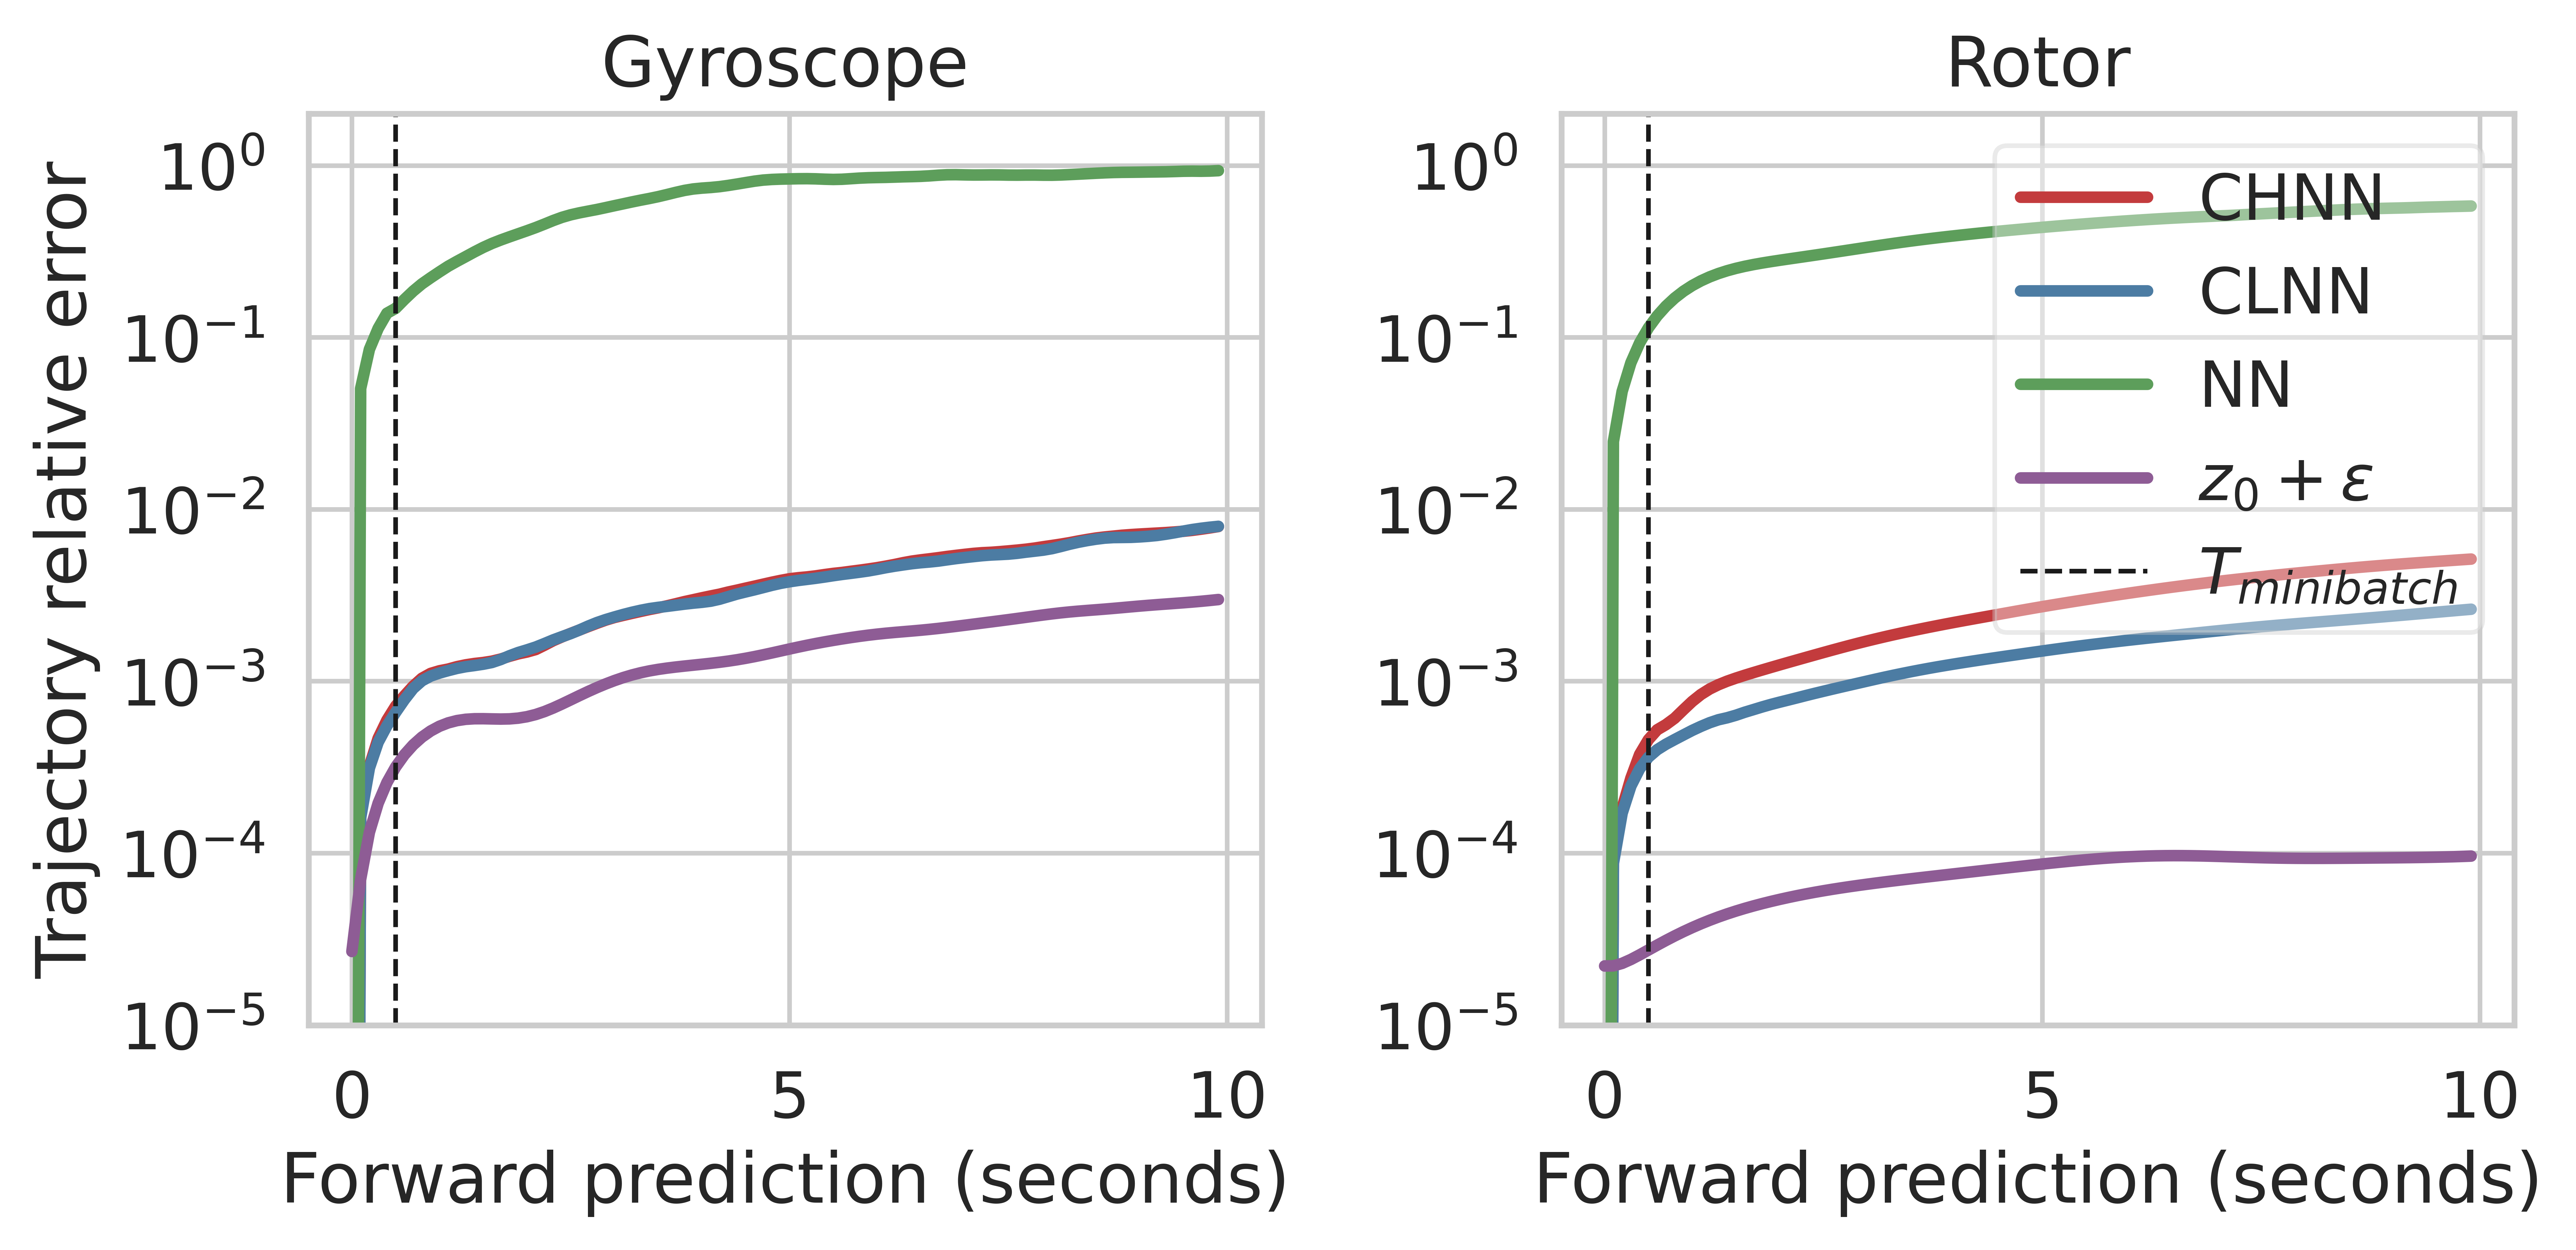

In [12]:
df_batch_avg = df.T.groupby(level=("Body", "Network", "Series")).mean().T

n_systems = len(df.columns.unique("Body"))
n_networks = len(df.columns.unique("Network"))

# TODO: uncomment when more than 1 system
fig, axes = plt.subplots(ncols=n_systems, figsize=(4 * n_systems, 4))
#fig, axes = plt.subplots(ncols=2, figsize=(4 * 2, 4))

for system, ax in zip(df.columns.unique("Body"), axes.flatten()):
    df_batch_avg.loc[:, (system, slice(None), "avg_rel_err_pred")].plot(ax=ax, linewidth=2.5)
    ax.set(yscale="log",
           title=system,
           xlabel=f"Forward prediction (seconds)",
           ylim=(1e-5, 2))
    
    # Just take the perturbation curve from NN
    df_batch_avg.loc[:, (system, "NN", "avg_rel_err_pert")].plot(ax=ax, linewidth=2.5)
    
    ax.axvline(chunk_len, label="Training trajectory length", color="k", linestyle="--", linewidth=1.0)
    
    # TODO: remember to order this correctly if new plots are added
    ax.get_legend().remove()
axes[-1].legend(list(df_batch_avg[system].columns.unique("Network")) + [r"$z_0 + \varepsilon$", r"$T_{minibatch}$"], framealpha=0.4,
                loc="upper right")
axes[0].set(ylabel=f"Trajectory relative error")
fig.tight_layout()

In [14]:
fig.savefig("non-pendulum-rel-err.pdf", bbox_inches="tight")

In [15]:
df_avg_int_err = df.apply(lambda y: np.exp(np.trapz(np.log(y + 1e-8), dx=dt) / integration_time))
df_avg_int_err = df_avg_int_err.T.groupby(level=("Body", "Network", "Series")).mean().T
df_avg_int_err.head()

Body       Network  Series          
Gyroscope  CHNN     avg_rel_err_pert    0.001196
                    avg_rel_err_pred    0.003008
           CLNN     avg_rel_err_pert    0.001175
                    avg_rel_err_pred    0.002873
           NN       avg_rel_err_pert    0.001315
dtype: float64

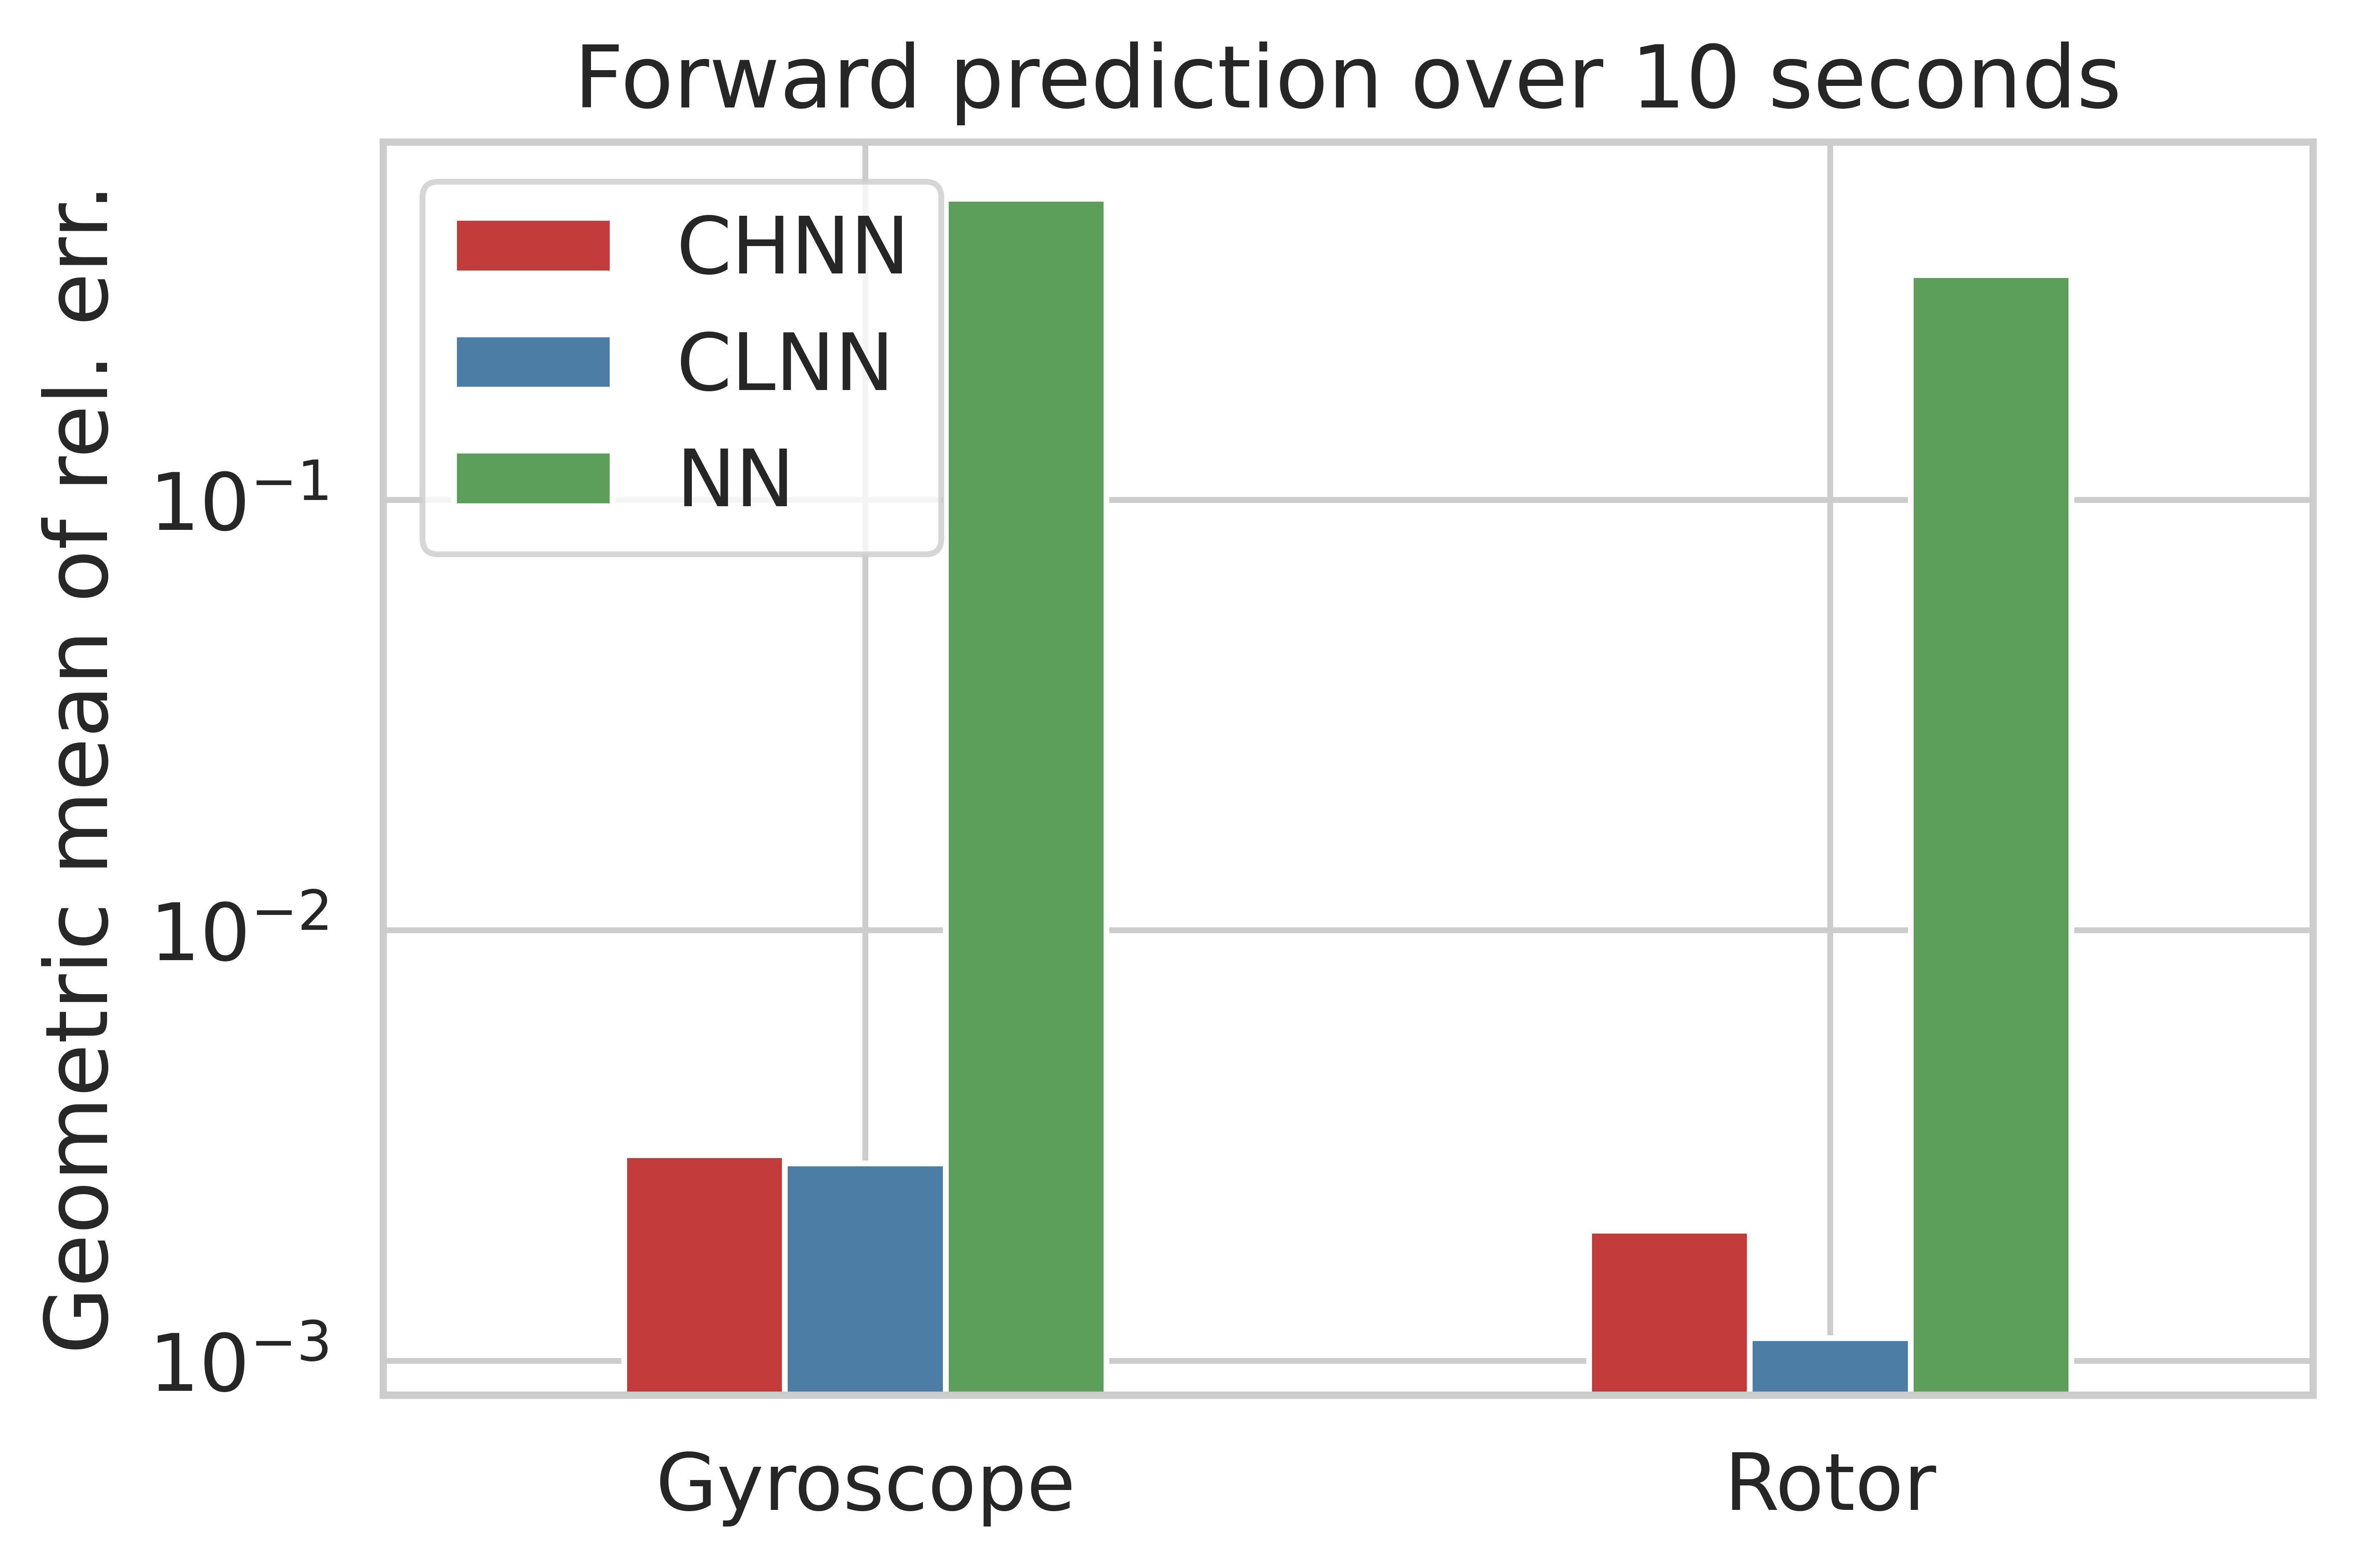

In [18]:
# TODO: uncomment when more than 1 system
#fig, axes = plt.subplots(ncols=n_systems, figsize=(4 * n_systems, 4))
fig, ax = plt.subplots()

df_avg_int_err.loc[(slice(None), slice(None), "avg_rel_err_pred")].unstack().plot(kind='bar', ax=ax)
ax.set(title=f"Forward prediction over {integration_time} seconds", yscale="log")
ax.set(ylabel="Geometric mean of rel. err.", xlabel="")
ax.set_xticklabels(list(df_batch_avg.columns.unique("Body")), rotation=0)
ax.legend(title=None, loc="upper left")
# TODO: remember to order this correctly if new plots are added
#ax.legend(list(df_batch_avg.columns.unique("Network")))

In [19]:
fig.savefig("non-pendulum-geom-mean.pdf", bbox_inches="tight")